# EDA

In [3]:
import pandas as pd
import numpy as np
import ast
import json
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

Carga de DataFrames

In [4]:
def load_json(file):
    with open(file,'r',encoding='utf-8') as file:
        data_list = []
        for line in file:
            try:
                data_list.append(json.loads(line))
            except ValueError:
                data =  ast.literal_eval(line)
                if isinstance(data, dict):
                    data_list.append(data)
    return pd.DataFrame(data_list)

# reviews = load_json('../dataset/australian_user_reviews.json')
# items = load_json('../dataset/australian_users_items.json')
games = load_json('../dataset/output_steam_games.json')

## Introducción

El presente EDA se enfoca en desglosar y comprender los patrones y tendencias dentro del conjunto de datos proporcionado por la plataforma [STEAM](https://drive.google.com/drive/folders/1HqBG2-sUkz_R3h1dZU5F2uAzpRn7BSpj). Este análisis exploratorio detallará las recomendaciones de los usuarios, quienes han clasificado videojuegos en un periodo que abarca desde el año 2010 hasta el 2015. Los datos sugieren que los usuarios pertenecen principalmente a la región de Australia. La interpretación de estos datos es crucial para entender las preferencias y comportamientos de los usuarios en la plataforma, lo cual puede influir en futuras estrategias de marketing y desarrollo de juegos.

La data se encuentra anidada en formato JSON para la mayoria de los archivos proporcionados en el archivo `dataset\australian_user_reviews.json` se procede a desanidar los datos y nos encotramos con las siguientes columnas:
- `funny`
- `posted`
- `last_edited`
- `item_id`
- `helpful`
-  `recommend`
- `review`
- `user_id`

In [180]:
reviews_explode = reviews.explode('reviews').reset_index()

lista = []
i = 0
while i<len(reviews_explode['reviews'])-1:
    if isinstance(reviews_explode['reviews'].loc[i],dict):
        dic = dict(reviews_explode['reviews'].loc[i])
        dic['user_id'] = reviews_explode['user_id'].loc[i]
        lista.append(dic)
    i += 1
reviews2 = pd.DataFrame(lista)

La columna `funny` expresa la cantidad de votos que indican que la review es divertida, por ello se procede a limpiar el dato eliminado las cadenas de texto y manteniendo la cantidad de votaciones 

In [187]:
reviews2['funny'] = reviews2['funny'].str.replace('1 person found this review funny','1')
reviews2['funny'] = reviews2['funny'].str.replace(' people found this review funny','')
reviews2['funny'] = reviews2['funny'].str.replace(',','')
reviews2['funny'] = pd.to_numeric(reviews2['funny'])
reviews2['funny'] = reviews2['funny'].fillna(0)
reviews2['funny'] = reviews2['funny'].astype(int)

La columna `helpful` es un indicador valioso dentro de nuestra base de datos, ya que refleja la cantidad de usuarios que han considerado una recomendación como adecuada y útil. Esta métrica nos permite evaluar la eficacia de las sugerencias proporcionadas y asegurar que estamos cumpliendo con las necesidades informativas de nuestros usuarios.

Por lo tanto se procesa la columna y se procede a generar 3 columnas que continenen el número de personas que valoraron como positivo el comentario (`found_helpful`) del total de usuarios que consultaron la review (`total_people`) y por último la proporcion de usuarios que encontraron util la recomendacion (`percentage`)

In [195]:
# Función para extraer los valores numéricos
def extract_numbers(review_stats_str):
    if review_stats_str == 'No stats available':
        return None, None, None
    
    pattern = r'(\d+) of (\d+) people \((\d+)%\)'
    match = re.search(pattern, review_stats_str)
    
    if match:
        found_helpful = int(match.group(1))
        total_people = int(match.group(2))
        percentage = int(match.group(3))
        return found_helpful, total_people, percentage
    else:
        return None, None, None

# Aplicar la función a la columna 'review_stats'
reviews2[['found_helpful', 'total_people', 'percentage']] = reviews2['helpful'].apply(lambda x: pd.Series(extract_numbers(x)))

In [203]:
reviews2['total_people'] = reviews2['total_people'].fillna(0).astype(int)
reviews2['found_helpful'] = reviews2['found_helpful'].fillna(0).astype(int)
reviews2['percentage'] = reviews2['percentage'].fillna(0)
reviews2.drop(columns=['helpful'],inplace=True)

Las columnas `posted` ofrecen información de cuándo fue publicada la recomendación, mientras que `last_edited` indica la fecha de la ultima edición del comentario

In [207]:
def convertir_fecha(fecha):
    # Utilizar expresión regular para extraer componentes de la fecha
    match = re.match(r"Posted (\w+) (\d+), (\d+)", fecha)
    if match:
        mes_str, dia_str, anio_str = match.groups()
        # Mapear nombres de meses a números
        meses = {
            'January': '01', 'February': '02', 'March': '03', 'April': '04',
            'May': '05', 'June': '06', 'July': '07', 'August': '08',
            'September': '09', 'October': '10', 'November': '11', 'December': '12'
        }
        # Crear la fecha en el nuevo formato
        nueva_fecha = f"{anio_str}-{meses[mes_str]}-{dia_str.zfill(2)}"
        return nueva_fecha
    else:
        return None
reviews2['posted'] = reviews2['posted'].apply(convertir_fecha)
reviews2['posted'] = pd.to_datetime(reviews2['posted'])

In [208]:
def convertir_fecha(fecha):
    # Utilizar expresión regular para extraer componentes de la fecha
    match = re.match(r"Last edited (\w+) (\d+), (\d+)", fecha)
    if match:
        mes_str, dia_str, anio_str = match.groups()
        # Mapear nombres de meses a números
        meses = {
            'January': '01', 'February': '02', 'March': '03', 'April': '04',
            'May': '05', 'June': '06', 'July': '07', 'August': '08',
            'September': '09', 'October': '10', 'November': '11', 'December': '12'
        }
        # Crear la fecha en el nuevo formato
        nueva_fecha = f"{anio_str}-{meses[mes_str]}-{dia_str.zfill(2)}"
        return nueva_fecha
    else:
        return None

reviews2['last_edited'] = reviews2['last_edited'].apply(convertir_fecha)
reviews2['last_edited'] = pd.to_datetime(reviews2['last_edited'])

La columna `item_id` hace referencia al identificador del videojuego que corresponde al dataset `dataset\output_steam_games.json`

In [210]:
reviews2['item_id'] = reviews2['item_id'].astype(int)

La columna `recommend` posee datos de tipo booleano el cual indica que el usuario recomienda el videojuego si el registro es `True`, de lo contrario no lo recomienda si es `False`

In [212]:
reviews2['recommend'].unique()

array([ True, False])

En la columna `reviews` encontramos la recomendación del usuario, para facilitar  el análisis de los comentarios se ha creado una nueva columna llamada `sentiment_analysis` la es discretizada con 3 posibles valore:
- 0, si el comentario es negativo
- 1, si el comentario es neutro
- 2, si el comentario es positivo

In [214]:
sia = SentimentIntensityAnalyzer()
def sentiment_analisys(data):
    try:
        value = sia.polarity_scores(data)['compound']
        if  value >= 0.05:          # Sentimiento positivo
            return 2
        elif  value <= -0.05:       #  Sentimiento negativo
            return 0
        else:
            return 1                # Sentimiento  neutral
    except:
        return 1

reviews2['sentiment_analysis'] = reviews2['review'].apply(lambda x: sentiment_analisys(x))   # Aplicando NLP

Podemos ver en la siguiente celda los tipos de datos del dataset, asi como las columnas (variables)

In [215]:
reviews2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59304 entries, 0 to 59303
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   funny               59304 non-null  int32         
 1   posted              49186 non-null  datetime64[ns]
 2   last_edited         4277 non-null   datetime64[ns]
 3   item_id             59304 non-null  int32         
 4   recommend           59304 non-null  bool          
 5   review              59304 non-null  object        
 6   user_id             59304 non-null  object        
 7   found_helpful       59304 non-null  int32         
 8   total_people        59304 non-null  int32         
 9   percentage          59304 non-null  float64       
 10  sentiment_analysis  59304 non-null  int64         
dtypes: bool(1), datetime64[ns](2), float64(1), int32(4), int64(1), object(2)
memory usage: 3.7+ MB


Las recomendaciones presentadas abarcan un periodo desde Octubre de 2010 hasta diciembre de 2015. Durante este tiempo, se ha observado una variabilidad significativa en los datos recopilados. Específicamente, las columnas `found_helpful` y `total_people` han mostrado valores atípicos que merecen una atención detallada. Los análisis cuartiles revelan que para `found_helpful`, los cuartiles Q1 y Q3 se sitúan en 0 y 1 respectivamente, mientras que para `total_people`, estos cuartiles son 0 y 2. Esta información es crucial para comprender las tendencias y patrones dentro del conjunto de datos y para tomar decisiones informadas basadas en estos hallazgos.

In [216]:
reviews2.describe()

,funny,posted,last_edited,item_id,found_helpful,total_people,percentage,sentiment_analysis
count,59304.000000,49186,4277,59304.000000,59304.000000,59304.000000,59304.000000,59304.000000
mean,1.194102,2014-09-08 16:51:37.466758400,2015-01-12 14:12:49.324292608,169938.034585,2.403312,3.935788,28.068663,1.468839
min,0.000000,2010-10-16 00:00:00,2013-11-25 00:00:00,10.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2014-02-20 00:00:00,2014-06-30 00:00:00,8930.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,2014-09-11 00:00:00,2015-01-30 00:00:00,218230.000000,0.000000,0.000000,0.000000,2.000000
75%,0.000000,2015-05-03 00:00:00,2015-07-25 00:00:00,261760.000000,1.000000,2.000000,57.000000,2.000000
max,2598.000000,2015-12-31 00:00:00,2015-12-31 00:00:00,527340.000000,831.000000,954.000000,100.000000,2.000000
std,25.632098,NaN,NaN,132028.742736,20.051826,26.526223,39.355347,0.757099


La gráfica de dispersión muestra la relación entre el índice de reseñas y la cantidad de usuarios que encontraron útil cada reseña de videojuegos. La mayoría de los puntos se concentran cerca del eje horizontal, lo que indica que un número menor de usuarios encontró útiles esas reseñas. Sin embargo, hay algunos puntos dispersos hacia arriba, lo que sugiere que algunas reseñas fueron consideradas útiles por un mayor número de usuarios. Esto puede indicar que ciertas reseñas son de alta calidad y han sido valiosas para muchos usuarios.

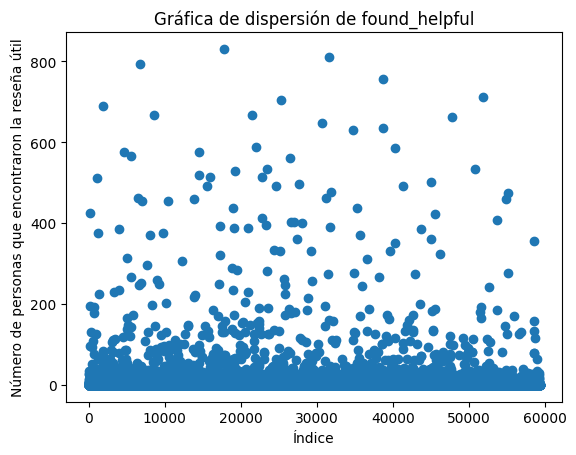

In [217]:
# Crear una figura y un objeto de ejes
fig, ax = plt.subplots()

# Trazar la gráfica de dispersión
ax.scatter(reviews2.index, reviews2['found_helpful'])

# Personalizar la gráfica
ax.set_title('Gráfica de dispersión de found_helpful')
ax.set_xlabel('Índice')
ax.set_ylabel('Número de personas que encontraron la reseña útil')

# Mostrar la gráfica
plt.show()

El histograma muestra la distribución de las fechas de publicación desde el año 2010 hasta el 2015. Se observa una baja frecuencia de publicación en los años 2010 a 2013, con un incremento notable en 2014 y un pico significativo en 2015. Esto sugiere que hubo un aumento considerable en la cantidad de datos o elementos publicados hacia el final del período representado.

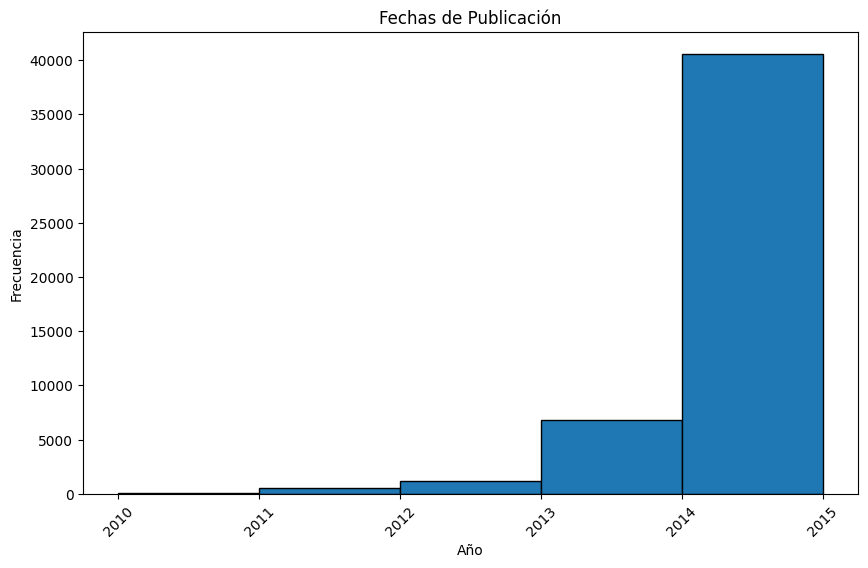

In [234]:
# Crear un histograma
plt.figure(figsize=(10, 6))
plt.hist(reviews2['posted'].dt.year, bins=5, edgecolor='black')

# Personalizar la gráfica
plt.title('Fechas de Publicación')
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

La gráfica de barras que representa el tipo de recomendaciones publicadas por los usuarios, clasificadas en "Positivo", "Neutro" y "Negativo". La barra "Positivo" es significativamente más alta, indicando una mayor cantidad de recomendaciones positivas en comparación con las neutras y negativas. Esto sugiere que la mayoría de los usuarios han tenido experiencias favorables y han compartido reseñas positivas.

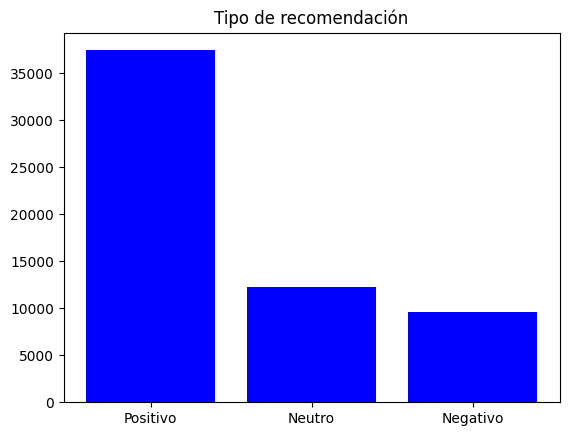

In [244]:
# Diccionario para mapear los valores a etiquetas
mapeo_etiquetas = {0: 'negativo', 1: 'Neutro', 2: 'Positivo'}

# Renombrar los valores usando el diccionario
etiquetas = [mapeo_etiquetas[val] for val in reviews2['sentiment_analysis']]

# Crear el histograma
plt.hist(etiquetas, bins=range(4), align='left', color='blue', rwidth=0.8)

# Establecer las etiquetas del eje x
plt.title('Tipo de recomendación')
plt.xticks(range(3), ['Positivo', 'Neutro', 'Negativo'])

# Mostrar el histograma
plt.show()


In [253]:
reviews2.to_parquet('../dataset/reviews_clean.parquet')

El dataset `dataset\australian_users_items.json` contiene información relevante a los videojuegos que cada usuario tiene asociado a su cuenta de STEAM, en la columna `items` hay una lista que contiene la siguiente información:
- `item_id`: Identificador único del videojuefo en la base de datos de STEAM
- `item_name`: Nombre del videojuego
- `playtime_forever`: Representa el tiempo total de juego acumulado “registrado” en minutos
- `playtime_2weeks`: Indica la cantidad de minutos que un usuario ha jugado en las últimas dos semanas

In [245]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  object
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [256]:
items_explode = items.explode('items').reset_index()

In [258]:
items_explode = items.explode('items').reset_index()
lista = []
i = 0
while i<len(items_explode['items'])-1:
    if isinstance(items_explode['items'].loc[i],dict):
        dic = dict(items_explode['items'].loc[i])
        dic['user_id'] = items_explode['user_id'].loc[i]
        lista.append(dic)
    i += 1
items2 = pd.DataFrame(lista)

In [262]:
items2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5153209 entries, 0 to 5153208
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   item_id           object
 1   item_name         object
 2   playtime_forever  int64 
 3   playtime_2weeks   int64 
 4   user_id           object
dtypes: int64(2), object(3)
memory usage: 196.6+ MB


In [261]:
items2.describe()

,playtime_forever,playtime_2weeks
count,5.153209e+06,5.153209e+06
mean,9.914951e+02,9.104707e+00
std,5.418204e+03,1.403926e+02
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,3.400000e+01,0.000000e+00
75%,3.550000e+02,0.000000e+00
max,6.427730e+05,1.996700e+04


El histograma muestra la distribución del tiempo total de juego de los usuarios. Las barras representan la frecuencia de usuarios según los minutos totales jugadas, en una escala logarítmica. La mayoría de los jugadores han acumulado alrededor de 10^3 (mil) minutos.

El gráfico de dispersión representa la relación entre el índice de cada usuario y su tiempo total de juego en horas. La concentración densa de puntos cerca del eje horizontal sugiere que la mayoría de los usuarios tienen un tiempo total de juego más bajo, mientras que los puntos dispersos hacia arriba indican que hay usuarios con tiempos de juego significativamente más altos. Este patrón puede reflejar que hay jugadores casuales que juegan menos horas y jugadores más dedicados o "hardcore" que invierten mucho más tiempo en los juegos de la plataforma Steam.


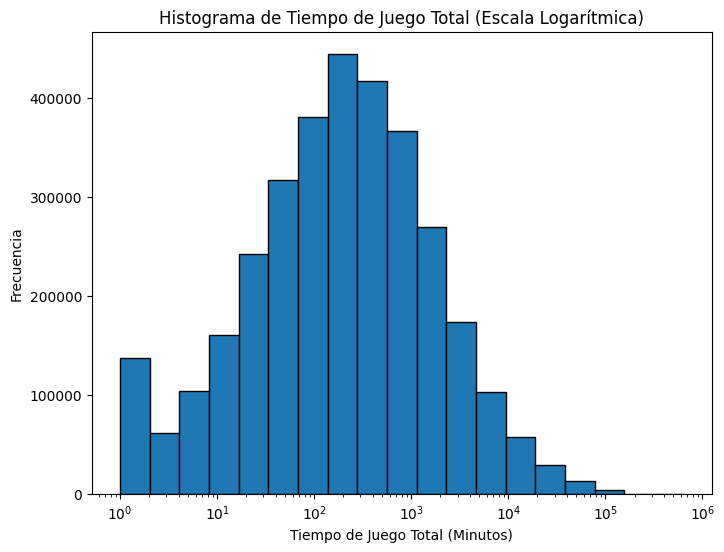

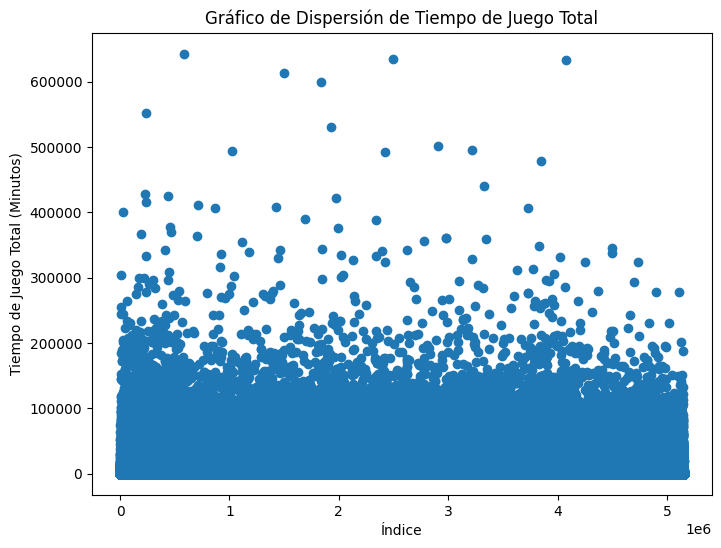

In [267]:
# Histograma con escala logarítmica
plt.figure(figsize=(8, 6))
log_bins = np.logspace(0, np.log10(items2['playtime_forever'].max()), 20)
plt.hist(items2['playtime_forever'], bins=log_bins, edgecolor='black')
plt.xscale('log')
plt.title('Histograma de Tiempo de Juego Total (Escala Logarítmica)')
plt.xlabel('Tiempo de Juego Total (Minutos)')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(items2.index, items2['playtime_forever'])
plt.title('Gráfico de Dispersión de Tiempo de Juego Total')
plt.xlabel('Índice')
plt.ylabel('Tiempo de Juego Total (Minutos)')
plt.show()

In [299]:
# items2.to_parquet('../dataset/items_clean.parquet')
items = pd.read_parquet('../dataset/items_clean.parquet')

Por último el dataset `dataset\output_steam_games.json`  contiene la información de los juegos que estan disponibles en STEAM, en este archivo podemos notar que existe una gran cantidad de registros nulos, se proceden a borrar los registros nulos siempre y cuando este nula la columna `title` y `app_name`

In [5]:
games.dropna(subset=['title', 'app_name'], inplace=True)
games = games.reset_index()

El dataset contiene las siguientes columnas:
- `publisher`: Empresa que publica el videojuego
- `genres`: Lista de generos que describe el videojuego
- `app_name`: Nombre de la aplicación
- `title`: Título del videojuego
- `url`: Dirección url del videojuego
- `release_date`: Fecha en que se lanzó el juego.
- `tags`: Lista de etiquetas que describen y categorizan al videojuego
- `reviews_url`: Url de las recomendaciones realizadas por los usuarios
- `specs`: Especificaciones del videojuego
- `price`: Precio de venta
- `early_access`: Indica si el videojuego está disponible bajo el modelo de “acceso anticipado”
- `id`: Idenitificador del  videojuego, único para cada uno, coincide con `item_id` para los otros datasets
- `developer`: Desarrollador

In [6]:
games['early_access'].unique()


array([False, True], dtype=object)

In [7]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30085 entries, 0 to 30084
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   index         30085 non-null  int64 
 1   publisher     24083 non-null  object
 2   genres        28851 non-null  object
 3   app_name      30085 non-null  object
 4   title         30085 non-null  object
 5   url           30085 non-null  object
 6   release_date  30067 non-null  object
 7   tags          29924 non-null  object
 8   reviews_url   30084 non-null  object
 9   specs         29416 non-null  object
 10  price         28825 non-null  object
 11  early_access  30085 non-null  object
 12  id            30084 non-null  object
 13  developer     28836 non-null  object
dtypes: int64(1), object(13)
memory usage: 3.2+ MB


In [8]:
games['release_date']  = pd.to_datetime(games['release_date'], errors='coerce')

In [9]:
list_free = ['Free To Play', 'Free to Play', 'Free Demo', 'Free', 'Free Demo', 'Play for Free!', 'Install Now',
             'Play WARMACHINE: Tactics Demo', 'Free Mod', 'Install Theme', 'Third-party', 'Play Now',
             'Free HITMAN™ Holiday Pack', 'Play the Demo', 'Starting at $', 'Starting at $', 'Free to Try',
             'Free Movie', 'Free to Use','Play for 0!','0 Mod','0 HITMAN™ Holiday Pack','0 to Use',
             '0 to Try','0 Movie']

i = 0

while i < len(list_free):
    games['price'] = games['price'].astype(str).str.replace(list_free[i], '0')
    i += 1  # Incrementar la variable i

In [10]:
games['price'] = pd.to_numeric(games['price'], errors='coerce')
games['price'] = games['price'].fillna(0)

In [11]:
games['id'] = games['id'].astype('Int32')

El gráfico de dispersión muestra la variabilidad en los precios de los videojuegos, con una concentración densa de puntos cerca del eje horizontal, indicando que muchos juegos tienen precios bajos. Algunos puntos se extienden hacia valores más altos, lo que sugiere que hay juegos con precios más elevados.

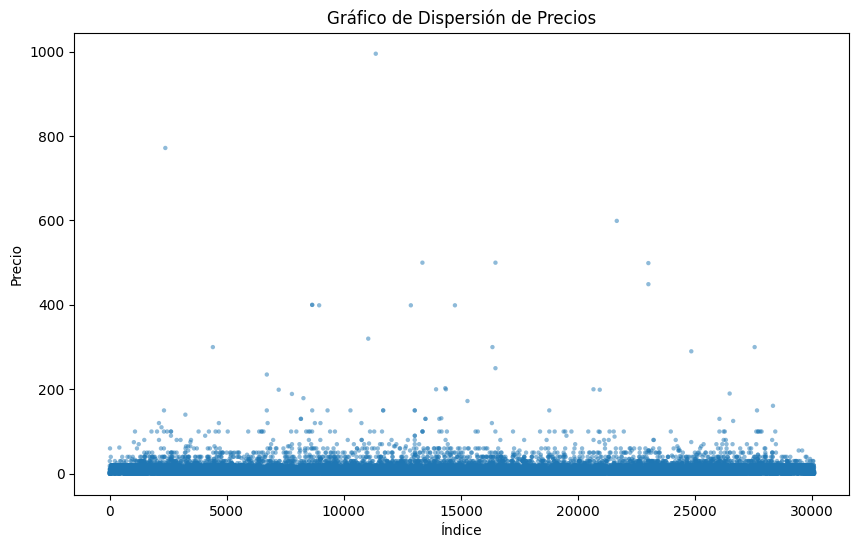

In [437]:
# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(games['price'].index, games['price'], s=10, edgecolors='none', alpha=0.5)
plt.title('Gráfico de Dispersión de Precios')
plt.xlabel('Índice')
plt.ylabel('Precio')

# Mostrar la gráfica
plt.show()

In [12]:
games.to_parquet('../dataset/games_clean.parquet')